# Sparse Gaussian implementation


In [1]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
from numpy.linalg import inv
from jax import random, jit, value_and_grad
from scipy.optimize import minimize


%matplotlib inline

In [2]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [6]:
#kernel: 

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


mean predict: 0.2776785804580269
std predict: 0.4150633912307968


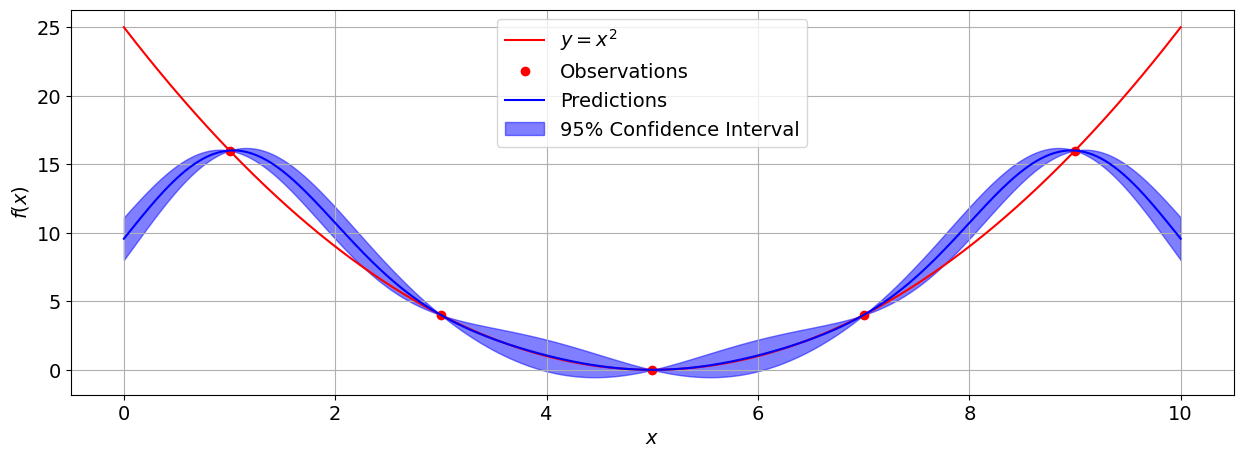

In [5]:
import matplotlib.pyplot as plt
import numpy as np

class RBF_Kernel:
    def __init__(self, X):
        self.X = X  
        self.kernel = np.zeros((X.shape[0], X.shape[0]))

    def make_kernel(self, l=1, sigma=1e-5):
        for i in range(self.kernel.shape[0]):
            for j in range(self.kernel.shape[1]):
                self.kernel[i, j] = self.Kernel(self.X[i], self.X[j])(l)

        return self.kernel + sigma * np.eye(len(self.kernel))

    class Kernel:
        def __init__(self, x_n, x_m):
            self.x_n = x_n
            self.x_m = x_m

        def __call__(self, l=1):
            ## RBF Kernel
            K = np.exp(-np.linalg.norm(self.x_n - self.x_m)**2 / (2 * l**2))
            return K

class GaussianProcess:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def predict_mean(self, X, y, X_new, sigma=1e-5):
        rbf_kernel = RBF_Kernel(np.vstack([X, X_new])).make_kernel(sigma=sigma)
        K = rbf_kernel[:len(X), :len(X)]
        k = rbf_kernel[:len(X), -1]
        return np.dot(np.dot(k, np.linalg.inv(K)), y)        
    
    def predict_std(self, X, X_new, sigma=1e-5):
        rbf_kernel = RBF_Kernel(np.vstack([X, X_new])).make_kernel(sigma=sigma)
        K = rbf_kernel[:len(X), :len(X)]
        k = rbf_kernel[:len(X), -1]
        return rbf_kernel[-1, -1] - np.dot(np.dot(k, np.linalg.inv(K)), k)
    
    def plot(self, f, sigma=1e-5):
        x = np.linspace(0, 10, 1000)
        y_pred = []
        y_std = []
        for i in range(len(x)):
            X_new = np.array([[x[i]]])  # Reshape X_new for compatibility
            y_pred.append(self.predict_mean(self.X, self.y, X_new, sigma=sigma))
            y_std.append(np.sqrt(self.predict_std(self.X, X_new, sigma=sigma)))
            
        y_pred = np.array(y_pred)
        y_std = np.array(y_std)
        plt.figure(figsize=(15, 5))
        plt.plot(x, f(x), "r")
        plt.plot(self.X, self.y, "ro")
        plt.plot(x, y_pred, "b-")
        plt.fill_between(x, y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, alpha=0.5, color="b")
        plt.xlabel("$x$", fontsize=14)
        plt.ylabel("$f(x)$", fontsize=14)
        plt.legend(["$y = x^2$", "Observations", "Predictions", "95% Confidence Interval"], fontsize=14)
        plt.grid(True)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()


if __name__ == "__main__":
    def f(x):
        return (x - 5) ** 2
    X = np.array([1.0, 3.0, 5.0, 7.0, 9.0])
    y = f(X)
    X = X.reshape(-1, 1)
    X_new = np.array([[5.5]])
    gp = GaussianProcess(X, y)
    mean_pred = gp.predict_mean(X, y, X_new)
    sigma_pred = np.sqrt(gp.predict_std(X, X_new))
    print(f"mean predict: {mean_pred}")
    print(f"std predict: {sigma_pred}")
    gp.plot(f)


In [7]:
%matplotlib inline
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

In [8]:
# noise free training data:

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [9]:
#noise_free data training 
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [13]:
#pred with noise
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot =plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


/var/folders/21/h599drp169j6rwhblvvjc4y00000gp/T/ipykernel_73264/394335200.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)


In [14]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)

In [15]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [16]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).
        theta: kernel parameters (2,)
    """

    sqdist = jnp.sum(X1 ** 2, 1).reshape(-1, 1) + jnp.sum(X2 ** 2, 1) - 2 * jnp.dot(X1, X2.T)
    return theta[1] ** 2 * jnp.exp(-0.5 / theta[0] ** 2 * sqdist)


def kernel_diag(d, theta):
    """
    Isotropic squared exponential kernel (computes diagonal elements only).
    """
    return jnp.full(shape=d, fill_value=theta[1] ** 2)

In [17]:
def jitter(d, value=1e-6):
    return jnp.eye(d) * value


def softplus(X):
    return jnp.log(1 + jnp.exp(X))


def softplus_inv(X):
    return jnp.log(jnp.exp(X) - 1)


def pack_params(theta, X_m):
    return jnp.concatenate([softplus_inv(theta), X_m.ravel()])


def unpack_params(params):
    return softplus(params[:2]), jnp.array(params[2:].reshape(-1, 1))


def nlb_fn(X, y, sigma_y):
    n = X.shape[0]

    def nlb(params):
        """
        Negative lower bound on log marginal likelihood.
        
        Args:
            params: kernel parameters `theta` and inducing inputs `X_m`
        """
        
        theta, X_m = unpack_params(params)

        K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
        K_mn = kernel(X_m, X, theta)

        L = jnp.linalg.cholesky(K_mm)  # m x m
        A = jsp.linalg.solve_triangular(L, K_mn, lower=True) / sigma_y  # m x n        
        AAT = A @ A.T  # m x m
        B = jnp.eye(X_m.shape[0]) + AAT  # m x m
        LB = jnp.linalg.cholesky(B)  # m x m
        c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True) / sigma_y  # m x 1

        # Equation (13)
        lb = - n / 2 * jnp.log(2 * jnp.pi)
        lb -= jnp.sum(jnp.log(jnp.diag(LB)))
        lb -= n / 2 * jnp.log(sigma_y ** 2)
        lb -= 0.5 / sigma_y ** 2 * y.T.dot(y)
        lb += 0.5 * c.T.dot(c)
        lb -= 0.5 / sigma_y ** 2 * jnp.sum(kernel_diag(n, theta))
        lb += 0.5 * jnp.trace(AAT)

        return -lb[0, 0]

    # nlb_grad returns the negative lower bound and 
    # its gradient w.r.t. params i.e. theta and X_m.
    nlb_grad = jit(value_and_grad(nlb))

    def nlb_grad_wrapper(params):
        value, grads = nlb_grad(params)
        # scipy.optimize.minimize cannot handle
        # JAX DeviceArray directly. a conversion
        # to Numpy ndarray is needed.
        return np.array(value), np.array(grads)

    return nlb_grad_wrapper

In [18]:
# Run optimization
res = minimize(fun=nlb_fn(X, y, sigma_y),
               x0=pack_params(jnp.array([1.0, 1.0]), X_m),
               method='L-BFGS-B',
               jac=True)

# Optimized kernel parameters and inducing inputs
theta_opt, X_m_opt = unpack_params(res.x)

In [19]:
# Run optimization
res = minimize(fun=nlb_fn(X, y, sigma_y),
               x0=pack_params(jnp.array([1.0, 1.0]), X_m),
               method='L-BFGS-B',
               jac=True)

# Optimized kernel parameters and inducing inputs
theta_opt, X_m_opt = unpack_params(res.x)

In [20]:
@jit
def phi_opt(theta, X_m, X, y, sigma_y):
    """Optimize mu_m and A_m using Equations (11) and (12)."""
    precision = (1.0 / sigma_y ** 2)

    K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
    K_mm_inv = jnp.linalg.inv(K_mm)
    K_nm = kernel(X, X_m, theta)
    K_mn = K_nm.T
    
    Sigma = jnp.linalg.inv(K_mm + precision * K_mn @ K_nm)
    
    mu_m = precision * (K_mm @ Sigma @ K_mn).dot(y)
    A_m = K_mm @ Sigma @ K_mm    
    
    return mu_m, A_m, K_mm_inv

mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_opt, X_m_opt, X, y, sigma_y)

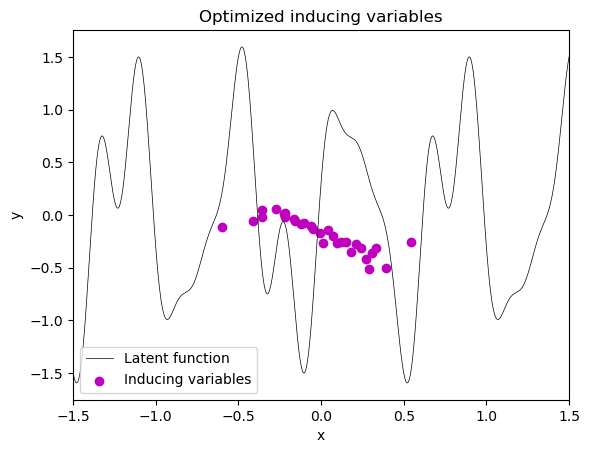

In [27]:

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.scatter(X_m_opt, mu_m_opt, label='Inducing variables', c='m')
plt.title('Optimized inducing variables')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()

In [22]:
@jit
def q(X_test, theta, X_m, mu_m, A_m, K_mm_inv):
    """
    Approximate posterior. 
    
    Computes mean and covariance of latent 
    function values at test inputs X_test.
    """
    
    K_ss = kernel(X_test, X_test, theta)
    K_sm = kernel(X_test, X_m, theta)
    K_ms = K_sm.T

    f_q = (K_sm @ K_mm_inv).dot(mu_m)
    f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms
    
    return f_q, f_q_cov

/var/folders/21/h599drp169j6rwhblvvjc4y00000gp/T/ipykernel_73264/658219611.py:3: RuntimeWarning: invalid value encountered in sqrt
  f_test_std = np.sqrt(f_test_var)


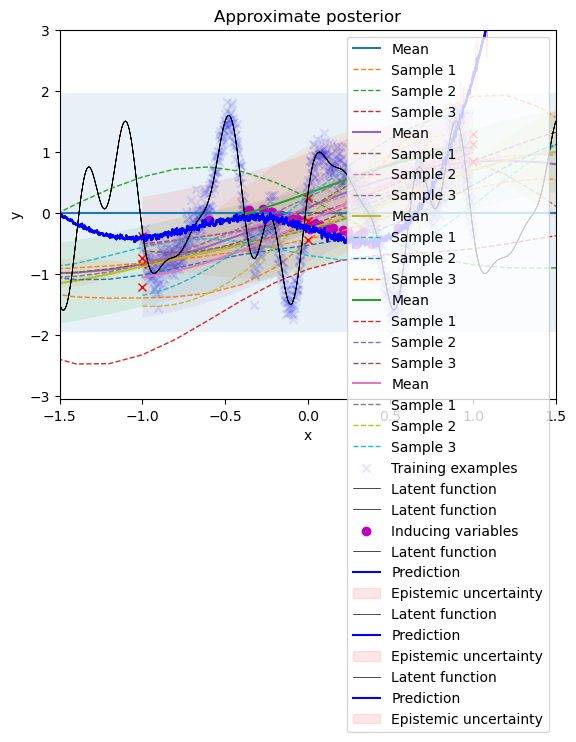

In [25]:
f_test, f_test_cov = q(X_test, theta_opt, X_m_opt, mu_m_opt, A_m_opt, K_mm_inv)
f_test_var = np.diag(f_test_cov)
f_test_std = np.sqrt(f_test_var)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std, 
                 f_test.ravel() - 2 * f_test_std,
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend()
plt.show()

In [28]:
theta_0 = jnp.array([1.0, 1.0])
theta_steps = [theta_0]

X_m_0 = X_m
X_m_steps = [X_m_0]

def callback(xk):
    theta, X_m = unpack_params(xk)
    theta_steps.append(theta)
    X_m_steps.append(X_m)
    return False

# Run optimization of kernel parameters and
# inducing inputs again and store their values
# at each step in global variables theta_steps
# and X_m_steps.
minimize(fun=nlb_fn(X, y, sigma_y),
         x0=pack_params(theta_0, X_m_0),
         method='L-BFGS-B', jac=True, 
         callback=callback);

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d

# Assuming X_m_last is a 1D array of shape (30,)
# and A_m_opt is a (30, 30) matrix

# Flatten the 2D arrays to 1D for interpolation
X_m_last_flat = X_m_last.ravel()  # This should give you a shape of (30,)
A_m_last_flat = A_m_opt.flatten()  # This gives you a shape of (900,) if A_m_opt is (30, 30)

# Ensure that you're interpolating correctly
# Here, we need to make sure A_m_last_flat and X_m_last_flat match in length
if len(X_m_last_flat) != len(A_m_last_flat):
    print("Error: X_m_last_flat and A_m_last_flat must have the same length!")
else:
    # Interpolate
    A_m_opt_interp = interp1d(X_m_last_flat, A_m_last_flat, bounds_error=False, fill_value="extrapolate")(X_test.ravel())
    
    # Reshape if needed
    A_m_opt_interp = A_m_opt_interp.reshape(X_test.shape)


def generate_static_plot(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q):
    fig, ax = plt.subplots()

    # Plot the latent function
    ax.plot(X_test, f_true, label='Latent function', color='k', lw=0.5)

    # Get the last optimized parameters
    mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_steps[-1], X_m_steps[-1], X, y, sigma_y)

    # Check shapes of the last optimization outputs
    print("Shape of X_m_steps[-1]:", X_m_steps[-1].shape)
    print("Shape of mu_m_opt:", mu_m_opt.shape)
    print("Shape of A_m_opt:", A_m_opt.shape)

    # Ensure X_m_steps[-1] is 1D
    X_m_last = X_m_steps[-1].ravel()  # Flatten if necessary

    # Interpolate mu_m_opt to match X_test
    interp_func = interp1d(X_m_last, mu_m_opt.ravel(), bounds_error=False, fill_value="extrapolate")
    mu_m_opt_interp = interp_func(X_test.ravel()).reshape(X_test.shape)
    print("Length of X_m_last:", len(X_m_last))
    print("Length of A_m_last:", len(A_m_last))
    # Interpolate A_m_opt if it's not already 1D
    A_m_last = A_m_opt.ravel()  # Flatten if necessary
    A_m_opt_interp = interp1d(X_m_last, A_m_last, bounds_error=False, fill_value="extrapolate")(X_test.ravel()).reshape(X_test.shape)


    # Plot the mean prediction
    ax.plot(X_test, mu_m_opt_interp, label='Mean prediction', color='b')

    # Plot uncertainty
    ax.fill_between(X_test.ravel(), 
                    mu_m_opt_interp + 2 * A_m_opt_interp, 
                    mu_m_opt_interp - 2 * A_m_opt_interp, 
                    color='r', alpha=0.1, label='Uncertainty')

    # Set titles and labels
    ax.set_title('Static Plot of Latent Function and Prediction')
    ax.set_ylim([-2, 2])  # Adjust y-limits as needed
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    
    plt.show()

# Call the function to generate a static plot
generate_static_plot(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q)


NameError: name 'X_m_last' is not defined

In [46]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation



import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def generate_animation(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q):
    # Set up the figure and axis
    fig, ax = plt.subplots()

    # Function to initialize the plot
    def init():
        ax.clear()
        ax.plot(X_test, f_true, label='Latent function', color='k', lw=0.5)
        ax.set_ylim([-2, 2])
        ax.legend()
        return ax

    # Function to update the plot for each frame
    def plot_step(i):
        ax.clear()
        # Example of updating based on your model's state
        mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_steps[i], X_m_steps[i], X, y, sigma_y)
        
        # You can plot updated predictions here
        ax.plot(X_test, mu_m_opt, label='Mean prediction')
        ax.fill_between(X_test.ravel(), mu_m_opt + 2 * A_m_opt, mu_m_opt - 2 * A_m_opt, color='r', alpha=0.1, label='Uncertainty')
        ax.set_title(f'Step {i + 1}')
        ax.legend()
        return ax

    # Generate animation with one frame per optimization step
    anim = FuncAnimation(fig, plot_step, frames=len(theta_steps), init_func=init, interval=200)

    # Prevent output of last frame as additional plot
    plt.close()
    return anim



# Generate animation with one frame per optimization step
anim = generate_animation(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q)

# Show animation widget
HTML(anim.to_jshtml())

ValueError: x and y must have same first dimension, but have shapes (1000, 1) and (30, 1)

50
Model: GPR L-BFGS-B, Dataset size: 10, Time: 0.0000 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: GPR L-BFGS-B, Dataset size: 20, Time: 0.0000 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: GPR L-BFGS-B, Dataset size: 30, Time: 0.0000 seconds, Memory: 0.01 MB,Uncertainty: 1.0000
Model: GPR L-BFGS-B, Dataset size: 40, Time: 0.0000 seconds, Memory: 0.01 MB,Uncertainty: 1.0000
Model: GPR L-BFGS-B, Dataset size: 50, Time: 0.0000 seconds, Memory: 0.02 MB,Uncertainty: 1.0000
Model: GPR ADAM, Dataset size: 10, Time: 0.0000 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: GPR ADAM, Dataset size: 20, Time: 0.0000 seconds, Memory: 0.00 MB,Uncertainty: 1.0000
Model: GPR ADAM, Dataset size: 30, Time: 0.0000 seconds, Memory: 0.01 MB,Uncertainty: 1.0000
Model: GPR ADAM, Dataset size: 40, Time: 0.0000 seconds, Memory: 0.01 MB,Uncertainty: 1.0000
Model: GPR ADAM, Dataset size: 50, Time: 0.0000 seconds, Memory: 0.02 MB,Uncertainty: 1.0000
Error in SGPR model: dot_general requires contr

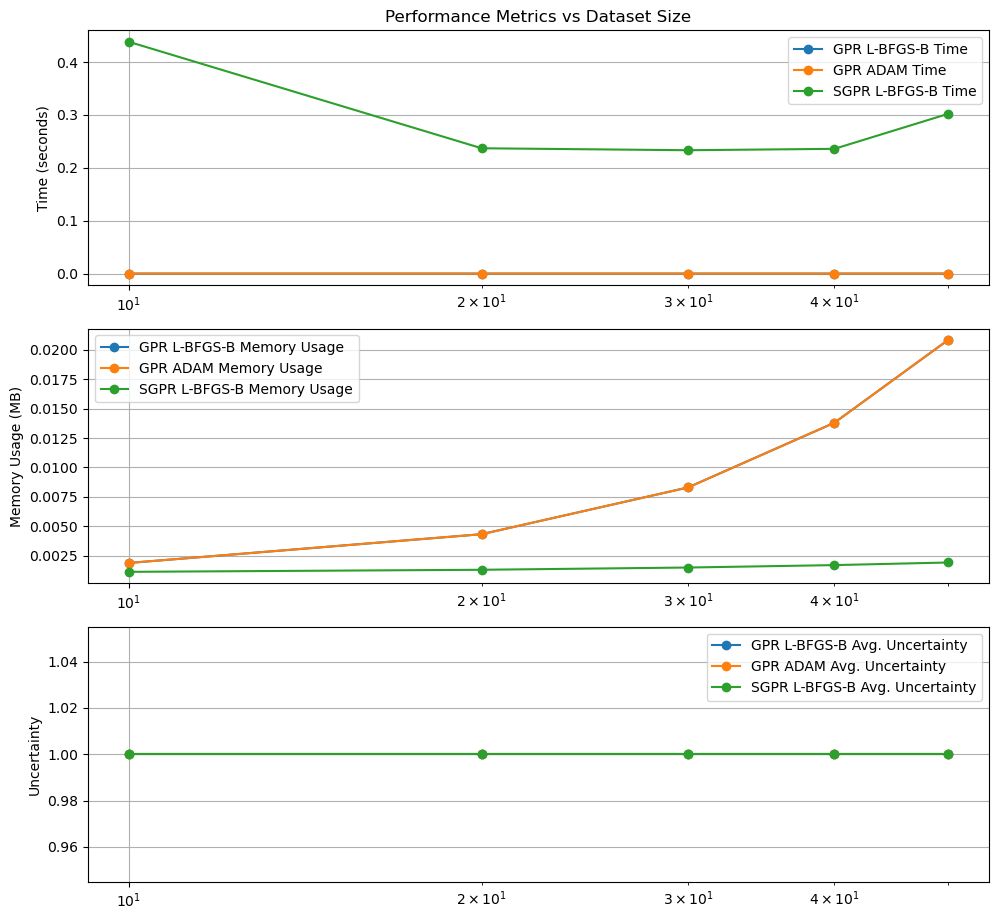

{'times': {'GPR L-BFGS-B': [3.814697265625e-06,
   3.0994415283203125e-06,
   2.1457672119140625e-06,
   3.0994415283203125e-06,
   2.1457672119140625e-06],
  'GPR ADAM': [1.9073486328125e-06,
   1.9073486328125e-06,
   2.1457672119140625e-06,
   9.5367431640625e-07,
   1.6689300537109375e-06],
  'SGPR L-BFGS-B': [0.4379901885986328,
   0.2368471622467041,
   0.23316597938537598,
   0.23577189445495605,
   0.30181002616882324]},
 'uncertainties': {'GPR L-BFGS-B': [1.0, 1.0, 1.0, 1.0, 1.0],
  'GPR ADAM': [1.0, 1.0, 1.0, 1.0, 1.0],
  'SGPR L-BFGS-B': [1.0, 1.0, 1.0, 1.0, 1.0]},
 'memory_usages': {'GPR L-BFGS-B': [0.00189208984375,
   0.00433349609375,
   0.00830078125,
   0.0137939453125,
   0.02081298828125],
  'GPR ADAM': [0.00189208984375,
   0.00433349609375,
   0.00830078125,
   0.0137939453125,
   0.02081298828125],
  'SGPR L-BFGS-B': [0.00113677978515625,
   0.001312255859375,
   0.00150299072265625,
   0.001708984375,
   0.00193023681640625]},
 'iterations': {}}

In [18]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt

from jax import random, jit, value_and_grad
from scipy.optimize import minimize



def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).
        theta: kernel parameters (2,)
    """
    sqdist = jnp.sum(X1 ** 2, 1).reshape(-1, 1) + jnp.sum(X2 ** 2, 1) - 2 * jnp.dot(X1, X2.T)
    return theta[1] ** 2 * jnp.exp(-0.5 / theta[0] ** 2 * sqdist)

def kernel_diag(d, theta):
    """
    Isotropic squared exponential kernel (computes diagonal elements only).
    """
    return jnp.full(shape=d, fill_value=theta[1] ** 2)

def jitter(d, value=1e-6):
    return jnp.eye(d) * value

def softplus(X):
    return jnp.log(1 + jnp.exp(X))

def softplus_inv(X):
    return jnp.log(jnp.exp(X) - 1)

def pack_params(theta, X_m):
    return jnp.concatenate([softplus_inv(theta), X_m.ravel()])

def unpack_params(params):
    return softplus(params[:2]), jnp.array(params[2:].reshape(-1, 1))

def nlb_fn(X, y, sigma_y):
    n = X.shape[0]

    def nlb(params):
        """
        Negative lower bound on log marginal likelihood.

        Args:
            params: kernel parameters theta and inducing inputs X_m
        """
        theta, X_m = unpack_params(params)

        K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
        K_mn = kernel(X_m, X, theta)

        L = jnp.linalg.cholesky(K_mm)  # m x m
        A = jsp.linalg.solve_triangular(L, K_mn, lower=True) / sigma_y  # m x n
        AAT = A @ A.T  # m x m
        B = jnp.eye(X_m.shape[0]) + AAT  # m x m
        LB = jnp.linalg.cholesky(B)  # m x m
        c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True) / sigma_y  # m x 1

        # Equation (13)
        lb = - n / 2 * jnp.log(2 * jnp.pi)
        lb -= jnp.sum(jnp.log(jnp.diag(LB)))
        lb -= n / 2 * jnp.log(sigma_y ** 2)
        lb -= 0.5 / sigma_y ** 2 * y.T.dot(y)
        lb += 0.5 * c.T.dot(c)
        lb -= 0.5 / sigma_y ** 2 * jnp.sum(kernel_diag(n, theta))
        lb += 0.5 * jnp.trace(AAT)

        return -lb[0, 0]

    # nlb_grad returns the negative lower bound and
    # its gradient w.r.t. params i.e. theta and X_m.
    nlb_grad = jit(value_and_grad(nlb))

    def nlb_grad_wrapper(params):
        value, grads = nlb_grad(params)
        # scipy.optimize.minimize cannot handle
        # JAX DeviceArray directly. a conversion
        # to Numpy ndarray is needed.
        return np.array(value), np.array(grads)

    return nlb_grad_wrapper

@jit
def phi_opt(theta, X_m, X, y, sigma_y):
    """Optimize mu_m and A_m using Equations (11) and (12)."""
    precision = (1.0 / sigma_y ** 2)

    K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
    K_mm_inv = jnp.linalg.inv(K_mm)
    K_nm = kernel(X, X_m, theta)
    K_mn = K_nm.T

    Sigma = jnp.linalg.inv(K_mm + precision * K_mn @ K_mn)

    mu_m = precision * (K_mm @ Sigma @ K_mn).dot(y)
    A_m = K_mm @ Sigma @ K_mm

    return mu_m, A_m, K_mm_inv

@jit
def q(X_test, theta, X_m, mu_m, A_m, K_mm_inv):
    """
    Approximate posterior.

    Computes mean and covariance of latent
    function values at test inputs X_test.
    """
    K_ss = kernel(X_test, X_test, theta)
    K_sm = kernel(X_test, X_m, theta)
    K_ms = K_sm.T

    f_q = (K_sm @ K_mm_inv).dot(mu_m)
    f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms

    return f_q, f_q_cov

# Function to estimate memory usage in bytes for the GP model components
def estimate_memory_usage(n_samples, n_features, model_type, n_inducing=None):
    # Memory for dataset (X_train and y_train)
    dataset_memory = n_samples * n_features * 8 + n_samples * 8  # X_train + y_train (float64, 8 bytes per float)

    if model_type == "GPR":
        # Full GP: Covariance matrix is N x N
        covariance_matrix_memory = n_samples ** 2 * 8  # N x N matrix, 8 bytes per float
    elif model_type == "SGPR":
        # Sparse GP: Covariance matrix is M x M (inducing points)
        if n_inducing is None:
            raise ValueError("n_inducing must be provided for SGPR")
        covariance_matrix_memory = n_inducing ** 2 * 8  # M x M matrix, 8 bytes per float

    # Memory for kernel parameters and gradients (assume around 1 KB for kernel + gradients)
    kernel_and_gradients_memory = 1024  # Rough estimation

    # Total memory usage estimate
    total_memory = dataset_memory + covariance_matrix_memory + kernel_and_gradients_memory

    return total_memory / (1024 ** 2)  # Convert to MB

# Define a simple GaussianProcess class
class GaussianProcess:
    def __init__(self, X_train, y_train, optim_method):
        self.X_train = X_train
        self.y_train = y_train
        self.optim_method = optim_method

    def fit(self):
        # Placeholder for fitting the model
        pass

    def predict(self, X_test):
        # Placeholder for making predictions
        mean = np.zeros(X_test.shape[0])
        variance = np.ones(X_test.shape[0])
        return mean, variance

# Function to train a GP model and return the RMSE, average uncertainty, time taken, and iteration count
def train_and_evaluate_gp(n_samples, model, optim_method):
    from sklearn.datasets import make_regression
    from sklearn.model_selection import train_test_split
    import time

    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=0.1, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    mean, variance = np.zeros(X_test.shape[0]), np.ones(X_test.shape[0])  # Default values
    start_time = time.time()

    if model == "GPR":
        model = GaussianProcess(X_train, y_train, optim_method)
        model.fit()
        mean, variance = model.predict(X_test)
    elif model == "SGPR":
        try:
            m = max(10, n_samples // 10)
            X_m = np.linspace(X_train.min(), X_train.max(), m).reshape(-1, 1)
            res = minimize(fun=nlb_fn(X_train, y_train.reshape(-1, 1), 0.1),
                           x0=pack_params(jnp.array([1.0, 1.0]), X_m),
                           method='L-BFGS-B', jac=True)
            theta_opt, X_m_opt = unpack_params(res.x)
            mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_opt, X_m_opt, X_train, y_train.reshape(-1, 1), 0.1)
            mean, variance = q(X_test, theta_opt, X_m_opt, mu_m_opt, A_m_opt, K_mm_inv)
            mean = mean.flatten()
            variance = np.diag(variance)
        except Exception as e:
            print(f"Error in SGPR model: {e}")
            # Optional: return a signal value or skip if the model fails

    end_time = time.time()
    time_taken = end_time - start_time

    rmse = np.sqrt(np.mean((mean - y_test) ** 2))
    avg_uncertainty = np.mean(np.sqrt(variance))

    return rmse, avg_uncertainty, time_taken


# General function to run comparison for multiple GP models
def run_comparison(max_samples, models_kernels):
    start = 10
    step = 10
    dataset_sizes = np.arange(start, max_samples + 1, step)
    print(max(dataset_sizes))

    # Dictionary to store results for each model
    results = {
        'times': {},
        'uncertainties': {},
        'memory_usages': {},
        'iterations': {}
    }

    # Loop over each model and its kernel
    for model_name, optim_method in models_kernels:
        times = []
        uncertainties = []
        memory_usages = []
        iterations = []

        for idx, size in enumerate(dataset_sizes):
            rmse, avg_uncertainty, time_taken = train_and_evaluate_gp(size, model_name, optim_method)
            memory = estimate_memory_usage(n_samples=size, n_features=1, model_type=model_name, n_inducing=0.1*size)

            uncertainties.append(avg_uncertainty)
            times.append(time_taken)
            memory_usages.append(memory)
            name = model_name + " " + optim_method
            print(f"Model: {name}, Dataset size: {size}, Time: {time_taken:.4f} seconds, "
                  f"Memory: {memory:.2f} MB,"
                  f"Uncertainty: {avg_uncertainty:.4f}")

        # Store results for this model
        results['times'][name] = times
        results['uncertainties'][name] = uncertainties
        results['memory_usages'][name] = memory_usages

    # Plotting the results
    plt.figure(figsize=(10, 12))

    # Time Plot
    plt.subplot(4, 1, 1)
    for name in results['times']:
        plt.plot(dataset_sizes, results['times'][name], 'o-', label=f'{name} Time')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Memory Usage Plot
    plt.subplot(4, 1, 2)
    for name in results['memory_usages']:
        plt.plot(dataset_sizes, results['memory_usages'][name], 'o-', label=f'{name} Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Uncertainty Plot
    plt.subplot(4, 1, 3)
    for name in results['uncertainties']:
        plt.plot(dataset_sizes, results['uncertainties'][name], 'o-', label=f'{name} Avg. Uncertainty')
    plt.ylabel('Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# Define the models and optimization methods to compare
models_kernels = [
    ("GPR", "L-BFGS-B"),
    ("GPR", "ADAM"),
    ("SGPR", "L-BFGS-B")
]

# Run the comparison for these models
run_comparison(max_samples=50, models_kernels=models_kernels)
